<a href="https://colab.research.google.com/github/Wyw021214/ISP_autism/blob/main/projects/fMRI/Actflow_HCP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q nilearn nibabel pandas numpy matplotlib requests boto3 awscli seaborn
!pip install -q nibabel nilearn numpy scikit-learn matplotlib pandas scipy
!pip install -q hcp_utils brainspace actflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 6.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.16 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Necessary for visualization
from nilearn import plotting, datasets

import h5py
import pkg_resources
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import sys
sys.path.insert(0, '../../')

#Used for plotting brain images inline
from wbplot import pscalar
import matplotlib.image as mpimg

import ActflowToolbox as actflow

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Generated by GPT, not yet verified

aal_network_labels = [
    "Visual", "Visual", "Visual", "Visual", "Somatomotor", "Somatomotor", "Somatomotor", "Somatomotor",
    "DorsalAttention", "DorsalAttention", "DorsalAttention", "DorsalAttention",
    "VentralAttention", "VentralAttention", "VentralAttention", "VentralAttention",
    "Limbic", "Limbic", "Limbic", "Limbic",
    "Frontoparietal", "Frontoparietal", "Frontoparietal", "Frontoparietal",
    "DefaultMode", "DefaultMode", "DefaultMode", "DefaultMode",
    "Subcortical", "Subcortical", "Subcortical", "Subcortical",
]

#Convert to numerical labels
network_dict = {net: idx for idx, net in enumerate(sorted(set(aal_network_labels)))}
network_labels_numeric = [network_dict[net] for net in aal_network_labels]

# Compute network order
netorder = np.argsort(network_labels_numeric)  # Sort ROIs by network

# Step 5️⃣: Print network order for verification
print(f"Network order indices: {netorder}")

Network order indices: [27 24 25 26 11  8  9 10 21 20 22 23 16 17 18 19  6  5  4  7 30 28 29 31
 15 13 12 14  3  2  1  0]


In [50]:
# Paths
output_base_dir = "/content/drive/MyDrive/HCP_1200_processed"

# List of subjects to process
subject_list_path = "/content/drive/MyDrive/hcp1200_subjects.txt"
with open(subject_list_path, "r") as file:
    subject_ids = [line.strip() for line in file.readlines()]

subject_ids = subject_ids[:30]  # Use the first 30 subjects
N_SUBJECTS = len(subject_ids)

task_conditions = [
    "tfMRI_WM_LR", "tfMRI_WM_RL",
    "tfMRI_SOCIAL_LR", "tfMRI_SOCIAL_RL"
]

# Task and resting-state data
N_PARCELS = 84  # Number of AAL parcels
N_TASKS = 4     # Number of tasks
TIME_CHUNK = 1200  # Average over 1200 time points

# Initialize lists to store valid subject data
valid_subjects = []
restdata_list = []
activations_list = []
problematic_subjects = []  # Store subjects with incorrect task shape

# Load data for each subject
for subj_idx, subject_id in enumerate(subject_ids):
    subject_output_dir = os.path.join(output_base_dir, subject_id)

    # Load resting-state data
    rest_file = os.path.join(subject_output_dir, "rest.npy")
    if os.path.exists(rest_file):
        subject_restdata = np.load(rest_file)  # Shape: (84, timepoints)

        # Average over chunks of 1200 time points
        num_chunks = subject_restdata.shape[1] // TIME_CHUNK
        subject_restdata_avg = np.mean(
            subject_restdata[:, :num_chunks * TIME_CHUNK].reshape(N_PARCELS, num_chunks, TIME_CHUNK),
            axis=1
        )  # Shape: (84, 1200)

    else:
        print(f"WARNING: Missing resting-state data for Subject {subject_id}")
        continue  # Skip this subject

    # Load task activations
    task_file = os.path.join(subject_output_dir, "task.npy")
    if os.path.exists(task_file):
        subject_taskdata = np.load(task_file)  # Expected Shape: (84, 4)

        # Check for shape mismatch
        if subject_taskdata.shape[1] != N_TASKS:
            print(f"WARNING: Subject {subject_id} has task data shape {subject_taskdata.shape}, expected (84, {N_TASKS})")
            problematic_subjects.append(subject_id)
            continue  # Skip this subject

    else:
        print(f"WARNING: Missing task data for Subject {subject_id}")
        continue  # Skip this subject

    # Only add valid subjects
    valid_subjects.append(subject_id)
    restdata_list.append(subject_restdata_avg)
    activations_list.append(subject_taskdata)

# Convert lists to numpy arrays
restdata = np.stack(restdata_list, axis=2)  # Shape: (84, 1200, valid_subjects_count)
activations_bycond = np.stack(activations_list, axis=2)  # Shape: (84, 4, valid_subjects_count)

# Verify final shape
print("Final Restdata shape:", restdata.shape)  # Expected: (84, 1200, valid_subjects_count)
print("Final Activations_bycond shape:", activations_bycond.shape)  # Expected: (84, 4, valid_subjects_count)


Final Restdata shape: (84, 1200, 29)
Final Activations_bycond shape: (84, 4, 29)


In [40]:
import numpy as np

def safe_corrcoef(X):
    """Compute correlation matrix with small regularization to avoid NaNs."""
    X = X - np.mean(X, axis=1, keepdims=True)  # Zero-center
    X_std = np.std(X, axis=1, keepdims=True)

    # Regularization: Avoid division by zero
    X_std[X_std == 0] = 1e-10  # Small nonzero value to prevent NaNs
    X = X / X_std
    return np.corrcoef(X)

# Add Small Noise to Zero-Variance ROIs (Keeps All 84 ROIs)
zero_variance_rois = np.std(restdata, axis=(1, 2)) == 0  # Identify flat ROIs
restdata[zero_variance_rois, :, :] += np.random.normal(scale=1e-10, size=restdata[zero_variance_rois, :, :].shape)

# Replace NaNs with Small Nonzero Value
restdata = np.nan_to_num(restdata, nan=1e-10)  # Replace NaNs

# Compute Pearson Correlation FC (Keeps All ROIs)
restFC_corr = np.zeros((N_PARCELS, N_PARCELS, restdata.shape[2]))

for subj_idx in range(restdata.shape[2]):
    subject_restdata = restdata[:, :, subj_idx]

    if np.isnan(subject_restdata).sum() > 0:
        print(f"⚠️ Warning: Subject {subj_idx} contains NaNs in `restdata`. Skipping FC calculation.")
        continue

    restFC_corr[:, :, subj_idx] = safe_corrcoef(subject_restdata)

nan_count = np.isnan(restFC_corr).sum()
if nan_count > 0:
    print(f"⚠️ Warning: {nan_count} NaN values detected in `restFC_corr` after computation.")

print("Functional Connectivity Matrix Computed Successfully")


Functional Connectivity Matrix Computed Successfully


In [41]:
%%time
# Perform activity flow mapping
print("== Activity flow mapping results, correlation-based resting-state FC, 4 task conditions ==")
actflowOutput_restFCCorr_bycond = actflow.actflowcomp.actflowtest(activations_bycond, restFC_corr)

== Activity flow mapping results, correlation-based resting-state FC, 4 task conditions ==
===Comparing prediction accuracies between models (similarity between predicted and actual brain activation patterns)===
 
==Comparisons between predicted and actual activation patterns, across all conditions and nodes:==
--Compare-then-average (calculating prediction accuracies before cross-subject averaging):
Each comparison based on 4 conditions across 84 nodes, p-values based on 29 subjects (cross-subject variance in comparisons)
 
Mean Pearson r = -0.07, t-value vs. 0: -4.31, p-value vs. 0: 0.00018097851315332987
 
Mean % variance explained (R^2 score, coeff. of determination) = -14.39
 
Mean MAE (mean absolute error) = 0.00
 
Note: Pearson r and Pearson r^2 are scale-invariant, while R^2 and MAE are not. R^2 units: percentage of the to-be-predicted data's unscaled variance, ranging from negative infinity (because prediction errors can be arbitrarily large) to positive 1. See https://scikit-

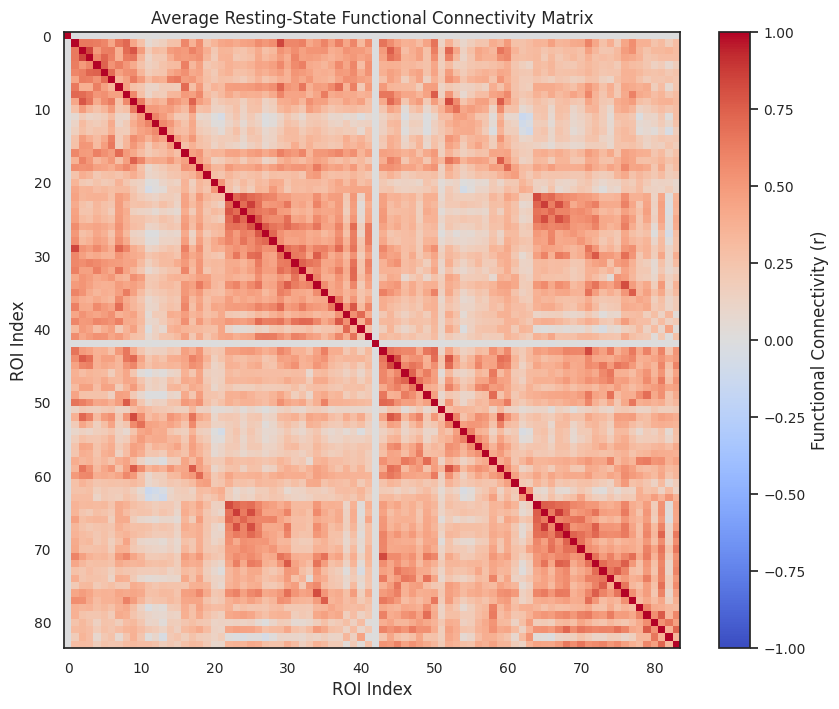

In [48]:
#Visualize FC matrix
avg_fc_matrix = np.mean(restFC_corr, axis=2)  # Shape: (84, 84)

# Visualize the FC matrix
plt.figure(figsize=(10, 8))
plt.imshow(avg_fc_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Functional Connectivity (r)")
plt.title("Average Resting-State Functional Connectivity Matrix")
plt.xlabel("ROI Index")
plt.ylabel("ROI Index")
plt.show()

[Text(54.75, 0.5, 'Regions')]

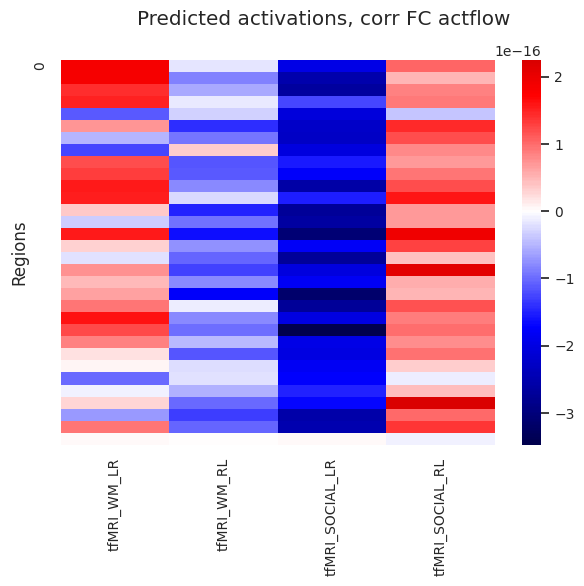

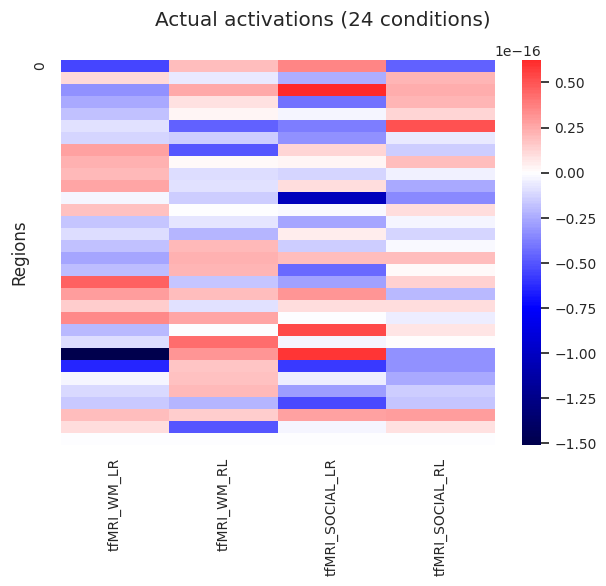

In [52]:
plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(actflowOutput_restFCCorr_bycond['actPredVector_bytask_bysubj'],axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=task_conditions)
ax.figure.suptitle('Predicted activations, corr FC actflow')
ax.set(ylabel='Regions')

plt.figure(figsize=[7,5])
ax = sns.heatmap(np.mean(activations_bycond,axis=2)[netorder,:],center=0,cmap='seismic',cbar=True,yticklabels=100,xticklabels=task_conditions)
ax.figure.suptitle('Actual activations (24 conditions)')
ax.set(ylabel='Regions')